In [23]:
from recommender_clustering import run_experiment
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os

def compute_metrics_all(
    dataset_names=['ml-small', 'ml-1m', 'books', 'jester'],
    method='hard',
    n_clusters_range=range(2, 101, 5),
    top_k_val=10,
    output_file='results.csv'
):
    """
    Ejecuta run_experiment para cada dataset en dataset_names
    y para cada valor de n_clusters en n_clusters_range.
    Guarda resultados en un CSV y permite resume si se interrumpe.
    """
    # Si existe archivo de resultados, cargar para saber qué ya se computó
    if os.path.exists(output_file):
        df_existing = pd.read_csv(output_file)
    else:
        # Crear DataFrame vacío con las columnas deseadas
        df_existing = pd.DataFrame(columns=[
            'dataset', 'method', 'n_clusters', 'top_k',
            'nmae', 'nrmse', 'entropy'
        ])

    # Iterar, saltar combinaciones ya en el archivo
    for ds in dataset_names:
        for n in tqdm(n_clusters_range, desc=f'Procesando {ds} ({method})'):
            # Verificar si ya existe esta configuración
            if not df_existing[
                (df_existing.dataset == ds) &
                (df_existing.method == method) &
                (df_existing.n_clusters == n) &
                (df_existing.top_k == top_k_val)
            ].empty:
                continue

            # Ejecutar experimento
            nmae, nrmse, entropy = run_experiment(
                dataset_name=ds,
                method=method,
                n_clusters_val=n,
                top_k_val=top_k_val
            )

            # Construir fila y escribir en CSV (modo append)
            row = {
                'dataset': ds,
                'method': method,
                'n_clusters': n,
                'top_k': top_k_val,
                'nmae': nmae,
                'nrmse': nrmse,
                'entropy': entropy
            }
            df_row = pd.DataFrame([row])
            df_row.to_csv(
                output_file,
                mode='a',
                header=not os.path.exists(output_file),
                index=False
            )

            # Agregar a df_existing para evitar recálculos en la misma ejecución
            df_existing = pd.concat([df_existing, df_row], ignore_index=True)

    print(f"Resultados guardados en {output_file}.")

def plot_metrics(
    sintetic,
    metrics,
    methods,
    results_file='results.csv',
    save=False,
    save_dir='../Memoria/Figuras'
):
    """
    Genera una comparativa de una o varias métricas frente al número de clústers.

    Parámetros:
    - sintetic: booleano. Si True, usa datasets sintéticos; si False, usa datasets reales.
    - metrics: string o lista de strings con nombres de columnas de métricas ('nmae', 'nrmse', 'entropy').
    - methods: string o lista de strings con los métodos ('hard', 'soft', etc.).
    - results_file: ruta al CSV con los resultados.
    - save: booleano, si True guarda la figura en formato PNG.
    - save_dir: directorio donde guardar la figura.
    """

    # Seleccionar datasets según el valor de sintetic
    if sintetic:
        datasets = ['syn', 'syn03', 'syn80']
        filename_suffix = 'sin'
    else:
        datasets = ['ml-small', 'ml-1m', 'jester', 'books']
        filename_suffix = 'all'

    # Colores fijos por dataset
    dataset_colors = {
        'ml-small': '#1f77b4',
        'ml-1m': '#ff7f0e',
        'books': '#2ca02c',
        'jester': '#d62728',
        'syn': '#9467bd',
        'syn03': '#8c564b',
        'syn80': '#e377c2'
    }

    # Asegurar listas
    if isinstance(metrics, str):
        metrics = [metrics]
    if isinstance(methods, str):
        methods = [methods]

    # Cargar datos
    df = pd.read_csv(results_file)

    # Preparar la figura
    plt.figure(figsize=(8, 6))

    # Plot para cada combinación de dataset, método y métrica
    for ds in datasets:
        color = dataset_colors.get(ds, 'black')  # Color por defecto: negro si no está definido
        for method in methods:
            df_sub = df[(df.dataset == ds) & (df.method == method)]
            for metric in metrics:
                plt.plot(
                    df_sub.n_clusters,
                    df_sub[metric],
                    marker='o',
                    label=f"{ds} - {method} - {metric}",
                    color=color
                )

    # Etiquetas y leyenda
    met_str = ",".join(metrics)
    plt.title(f"Comparativa {met_str} vs Número de Clústers")
    plt.xlabel("Número de Clústers")
    plt.ylabel(met_str)
    plt.legend()
    plt.grid(True)

    # Guardar si se solicita
    if save:
        os.makedirs(save_dir, exist_ok=True)
        filename = f"{met_str}-{'-'.join(methods)}-{filename_suffix}.png"
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        print(f"Figura guardada en {os.path.join(save_dir, filename)}")

    # Mostrar plot
    plt.show()

def plot_metrics_single_dataset(
    dataset: str,
    metrics,
    methods,
    results_file: str = 'results.csv',
    save: bool = False,
    save_dir: str = '../Memoria/Figuras'
):
    """
    Genera una comparativa de una o varias métricas frente al número de clústers
    para un dataset específico y una serie de métodos.
    La leyenda se muestra dentro del gráfico.

    Parámetros:
    - dataset: string, nombre del dataset a analizar (ej. 'ml-small', 'syn').
    - metrics: string o lista de strings con nombres de columnas de métricas ('nmae', 'rmse', 'entropy').
    - methods: string o lista de strings con los métodos ('hard', 'soft', etc.).
    - results_file: ruta al CSV con los resultados.
    - save: booleano, si True guarda la figura en formato PNG.
    - save_dir: directorio donde guardar la figura.
    """

    # Asegurar que metrics y methods sean listas
    if isinstance(metrics, str):
        metrics = [metrics]
    if isinstance(methods, str):
        methods = [methods]

    # Cargar datos
    try:
        df = pd.read_csv(results_file)
    except FileNotFoundError:
        print(f"Error: El archivo de resultados '{results_file}' no fue encontrado.")
        return
    except pd.errors.EmptyDataError:
        print(f"Error: El archivo de resultados '{results_file}' está vacío.")
        return

    # Colores para los métodos y estilos de línea para las métricas
    method_color_palette = plt.cm.get_cmap('tab10').colors
    metric_linestyle_palette = ['-', '--', ':', '-.']

    # Preparar la figura
    plt.figure(figsize=(8, 6)) # Volvemos al tamaño original, más adecuado para leyenda interna

    # Filtrar el DataFrame por el dataset especificado
    df_dataset = df[df.dataset == dataset]

    if df_dataset.empty:
        print(f"Advertencia: No se encontraron datos para el dataset '{dataset}' en '{results_file}'.")
        return

    plot_has_data = False
    for i, method in enumerate(methods):
        df_method = df_dataset[df_dataset.method == method]

        if df_method.empty:
            print(f"Advertencia: No se encontraron datos para el método '{method}' en el dataset '{dataset}'.")
            continue

        color = method_color_palette[i % len(method_color_palette)]

        for j, metric in enumerate(metrics):
            if metric not in df_method.columns:
                print(f"Advertencia: La métrica '{metric}' no existe en los datos para el método '{method}' y dataset '{dataset}'.")
                continue
            
            if df_method[metric].isnull().all():
                print(f"Advertencia: Todos los valores son NaN para la métrica '{metric}', método '{method}', dataset '{dataset}'.")
                continue

            linestyle = metric_linestyle_palette[j % len(metric_linestyle_palette)]
            
            df_plot = df_method.sort_values(by='n_clusters')

            plt.plot(
                df_plot.n_clusters,
                df_plot[metric],
                marker='o',
                linestyle=linestyle,
                color=color,
                label=f"{method} - {metric}" # Etiqueta más concisa para leyenda interna
            )
            plot_has_data = True

    if not plot_has_data:
        print(f"No se pudo generar ninguna línea para el dataset '{dataset}' con los métodos y métricas especificados.")
        plt.close()
        return

    # Etiquetas y leyenda
    metrics_str_title = ", ".join(metrics)
    # El título de la leyenda original era implícito o no existía.
    # Aquí podemos poner un título a la leyenda si hay múltiples tipos de información,
    # o dejarlo vacío si solo hay una (ej. solo métodos, o solo datasets).
    # En este caso, la etiqueta de cada línea ya es "método - métrica",
    # por lo que un título adicional para la leyenda podría ser redundante.
    
    # Leyenda DENTRO del gráfico. Matplotlib intentará encontrar la mejor ubicación.
    # plt.legend(title="Método - Métrica") # Título opcional para la leyenda
    plt.legend()


    plt.title(f"Comparativa {metrics_str_title} vs. Número de Clústers\nDataset: {dataset}")
    plt.xlabel("Número de Clústers")
    
    if len(set(m.replace('n','')[:3] for m in metrics)) == 1 and len(metrics)>0:
        base_metric_name = metrics[0].upper().replace('NMAE','NMAE').replace('NRMSE','NRMSE')
        ylabel_str = base_metric_name
    else:
        ylabel_str = metrics_str_title # Usamos el mismo string que para el título

    plt.ylabel(ylabel_str)
    plt.grid(True)
    plt.tight_layout() # Ajusta automáticamente los subparámetros para dar un layout ajustado.

    # Guardar si se solicita
    if save:
        os.makedirs(save_dir, exist_ok=True)
        filename_metrics = "-".join(sorted(list(set(m.lower() for m in metrics))))
        filename_methods = "-".join(sorted(list(set(m.lower() for m in methods))))
        # Para el nombre del archivo, usamos el mismo formato que en la función original
        # si es que se refería a 'filename_suffix'
        # La función original tenía un filename_suffix 'sin' o 'all' basado en si era sintético o no.
        # Como ahora es un solo dataset, podemos usar el nombre del dataset.
        filename = f"{metrics_str_title.replace(', ','-')}-{filename_methods}-{dataset}.png"
        # Ajustamos el nombre del archivo para que sea más parecido al original,
        # pero con la info relevante del dataset
        # Original: f"{met_str}-{'-'.join(methods)}-{filename_suffix}.png"
        
        # Recreando el formato del nombre de archivo de la función original:
        met_str_filename = "-".join(metrics) # 'nmae-rmse' o 'nmae'
        methods_str_filename = "-".join(methods) # 'hard-soft' o 'hard'
        # El suffix era 'sin' o 'all'. Usaremos el nombre del dataset como suffix.
        filename_original_style = f"{met_str_filename}-pear-{dataset}.png"

        save_path = os.path.join(save_dir, filename_original_style)
        plt.savefig(save_path, dpi=300, bbox_inches='tight') # bbox_inches='tight' es bueno para guardar
        print(f"Figura guardada en {save_path}")

    # Mostrar plot
    plt.show()

## Kmeans Euclidean

In [47]:
n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='hard',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='hard_pearson',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='fuzzy',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='fuzzy_pearson',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='hac',
    n_clusters_range=n_clusters,
    top_k_val=10
)

n_clusters = range(2, 101, 5)
compute_metrics_all(
    dataset_names=['ml-small','ml-1m','books','jester', 'syn', 'syn03', 'syn80'],
    method='hac_pearson',
    n_clusters_range=n_clusters,
    top_k_val=10
)

Procesando syn80 (hard): 100%|██████████| 20/20 [00:00<00:00, 1997.19it/s]


Resultados guardados en results.csv.


Procesando syn80 (hard_pearson): 100%|██████████| 20/20 [00:00<00:00, 2096.99it/s]


Resultados guardados en results.csv.


Procesando syn80 (fuzzy): 100%|██████████| 20/20 [00:00<00:00, 1972.68it/s]


Resultados guardados en results.csv.


Procesando syn80 (fuzzy_pearson): 100%|██████████| 20/20 [14:23:00<00:00, 2589.05s/it]  


Resultados guardados en results.csv.


Procesando syn80 (hac): 100%|██████████| 20/20 [48:44<00:00, 146.23s/it]


Resultados guardados en results.csv.


Procesando syn80 (hac_pearson): 100%|██████████| 20/20 [45:32<00:00, 136.63s/it]

Resultados guardados en results.csv.


Figura guardada en ../Memoria/Figuras/nmae-hac-sin.png


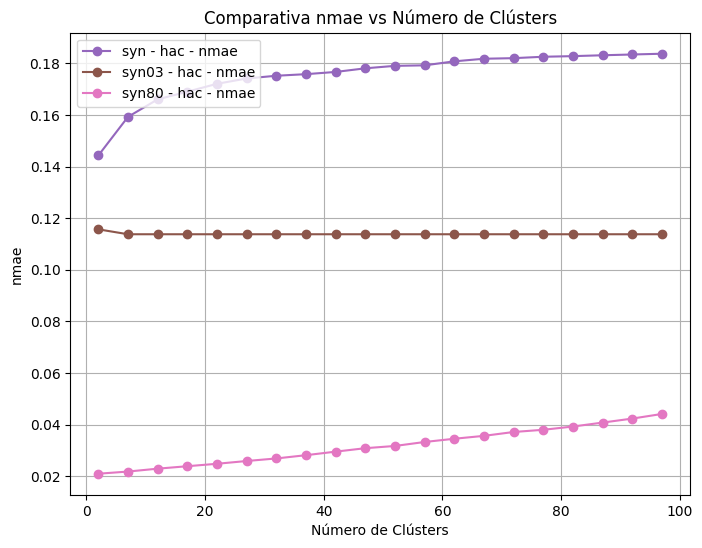

Figura guardada en ../Memoria/Figuras/nrmse-hac-sin.png


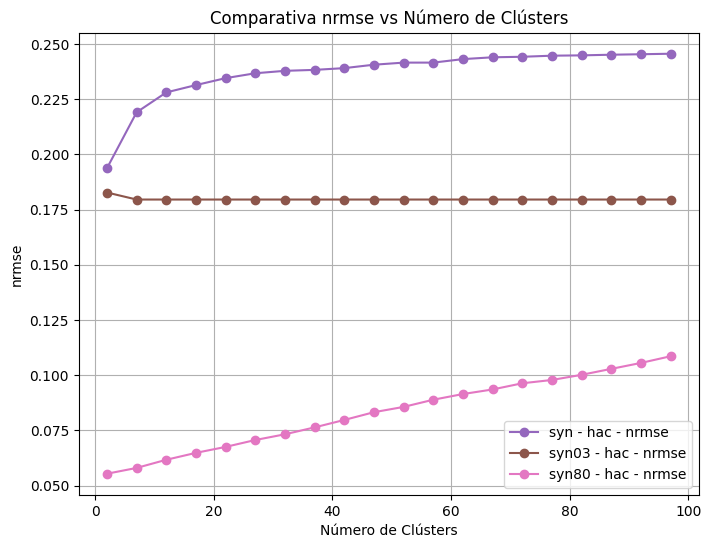

Figura guardada en ../Memoria/Figuras/entropy-hac-sin.png


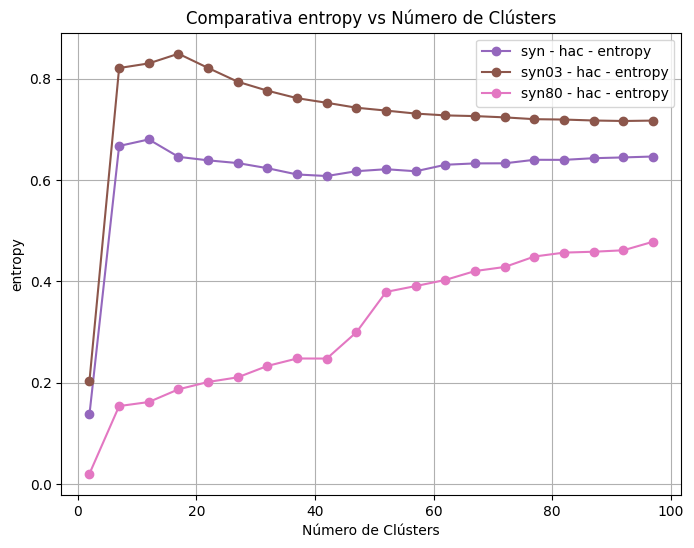

In [5]:
plot_metrics(
    sintetic=True,
    metrics=['nmae'],
    methods=['hac'],
    results_file='results.csv',
    save=True,
    save_dir='../Memoria/Figuras'
)

plot_metrics(
    sintetic=True,
    metrics=['nrmse'],
    methods=['hac'],
    results_file='results.csv',
    save=True,
    save_dir='../Memoria/Figuras'
)

plot_metrics(
    sintetic=True,
    metrics=['entropy'],
    methods=['hac'],
    results_file='results.csv',
    save=True,
    save_dir='../Memoria/Figuras'
)

Figura guardada en ../Memoria/Figuras/nmae-hac_pearson-sin.png


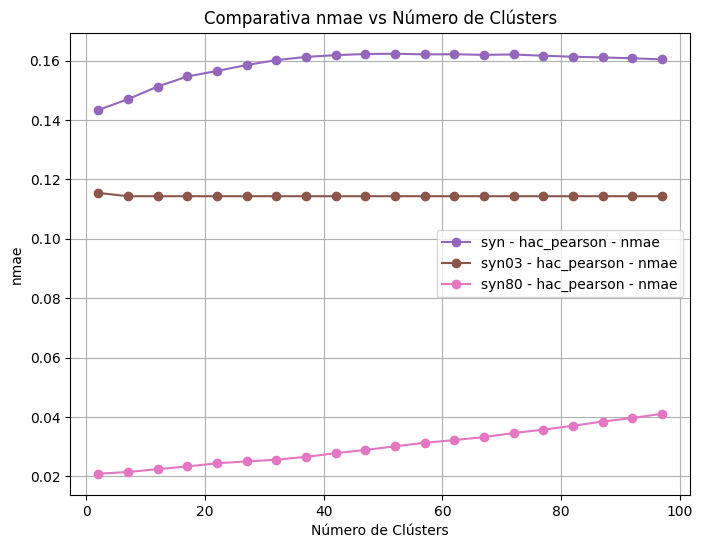

Figura guardada en ../Memoria/Figuras/nrmse-hac_pearson-sin.png


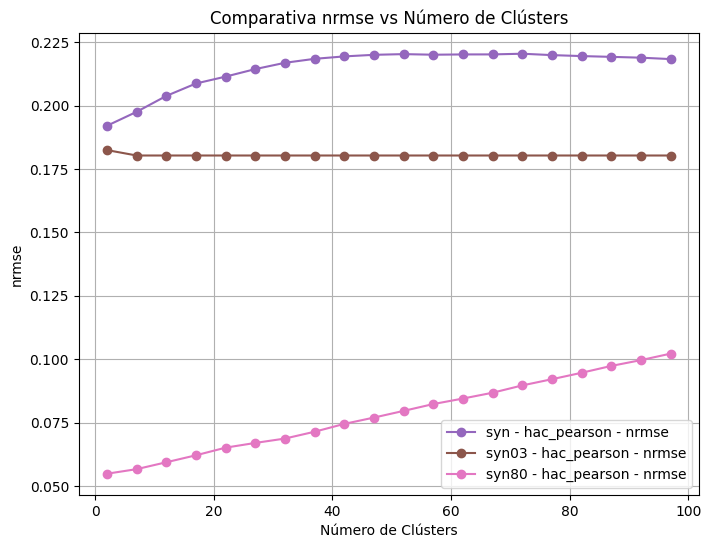

Figura guardada en ../Memoria/Figuras/entropy-hac_pearson-sin.png


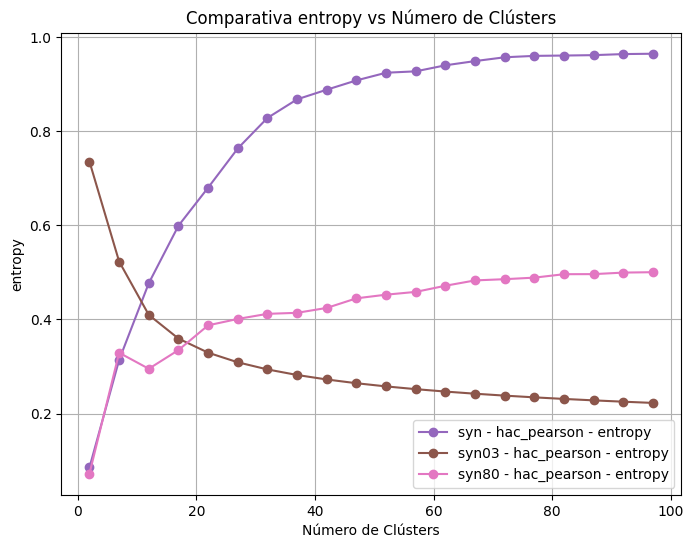

In [6]:
plot_metrics(
    sintetic=True,
    metrics=['nmae'],
    methods=['hac_pearson'],
    results_file='results.csv',
    save=True,
    save_dir='../Memoria/Figuras'
)

plot_metrics(
    sintetic=True,
    metrics=['nrmse'],
    methods=['hac_pearson'],
    results_file='results.csv',
    save=True,
    save_dir='../Memoria/Figuras'
)

plot_metrics(
    sintetic=True,
    metrics=['entropy'],
    methods=['hac_pearson'],
    results_file='results.csv',
    save=True,
    save_dir='../Memoria/Figuras'
)

In [10]:
def compute_metrics_met(
    dataset_names=['ml-small', 'ml-1m', 'books', 'jester'],
    methods=['hard'],  # Modificado: ahora es 'methods' y espera una lista
    n_clusters_range=range(2, 101, 5),
    top_k_val=10,
    output_file='results.csv'
):
    """
    Ejecuta run_experiment para cada dataset en dataset_names,
    para cada método en methods, y para cada valor de n_clusters
    en n_clusters_range.
    Guarda resultados en un CSV y permite resume si se interrumpe.
    """
    # Asegurarse de que 'methods' sea una lista, incluso si se pasa un solo string
    if isinstance(methods, str):
        methods = [methods]

    # Si existe archivo de resultados, cargar para saber qué ya se computó
    if os.path.exists(output_file):
        try:
            df_existing = pd.read_csv(output_file)
        except pd.errors.EmptyDataError: # Si el archivo existe pero está vacío
            df_existing = pd.DataFrame(columns=[
                'dataset', 'method', 'n_clusters', 'top_k',
                'nmae', 'nrmse', 'entropy'
            ])
    else:
        # Crear DataFrame vacío con las columnas deseadas
        df_existing = pd.DataFrame(columns=[
            'dataset', 'method', 'n_clusters', 'top_k',
            'nmae', 'nrmse', 'entropy'
        ])

    # Iterar, saltar combinaciones ya en el archivo
    for ds in dataset_names:
        for current_method in methods: # Nuevo bucle para iterar sobre los métodos
            # Actualizar la descripción de tqdm para incluir el método actual
            for n in tqdm(n_clusters_range, desc=f'Procesando {ds} ({current_method})'):
                # Verificar si ya existe esta configuración
                # Asegurarse de que df_existing no esté vacío antes de filtrar
                already_computed = False
                if not df_existing.empty:
                    if not df_existing[
                        (df_existing.dataset == ds) &
                        (df_existing.method == current_method) & # Usar current_method
                        (df_existing.n_clusters == n) &
                        (df_existing.top_k == top_k_val)
                    ].empty:
                        already_computed = True
                
                if already_computed:
                    # print(f"Saltando: {ds}, {current_method}, {n} (ya existe)") # Descomentar para depuración
                    continue

                # Ejecutar experimento
                nmae, nrmse, entropy = run_experiment(
                    dataset_name=ds,
                    method=current_method, # Pasar el método actual
                    n_clusters_val=n,
                    top_k_val=top_k_val
                )

                # Construir fila y escribir en CSV (modo append)
                row = {
                    'dataset': ds,
                    'method': current_method, # Guardar el método actual
                    'n_clusters': n,
                    'top_k': top_k_val,
                    'nmae': nmae,
                    'nrmse': nrmse,
                    'entropy': entropy
                }
                df_row = pd.DataFrame([row])
                
                # Escribir encabezado solo si el archivo no existe o está vacío
                write_header = not os.path.exists(output_file) or os.path.getsize(output_file) == 0
                df_row.to_csv(
                    output_file,
                    mode='a',
                    header=write_header,
                    index=False
                )

                # Agregar a df_existing para evitar recálculos en la misma ejecución
                # y para que la verificación de "already_computed" funcione correctamente en la misma ejecución
                df_existing = pd.concat([df_existing, df_row], ignore_index=True)
    
    # Limpiar las barras de progreso de tqdm si se usó leave=False
    # Esto es más relevante en entornos de consola. En notebooks, leave=False suele ser bueno.
    # tqdm.write("") # Opcional, para asegurar una nueva línea después de las barras
    
    print(f"Resultados guardados en {output_file}.")

In [19]:
hac_methods_euclidean = ['hac', 'hac_W', 'hac_CE', 'hac_S', 'hac_CO']
hac_methods_pearson = ['hac_pearson', 'hac_pearson_W', 'hac_pearson_CE', 'hac_pearson_S', 'hac_pearson_CO']

n_clusters = range(2, 101, 5)
compute_metrics_met(
    dataset_names=['ml-small'],
    methods=hac_methods_euclidean,
    n_clusters_range=n_clusters,
    top_k_val=10,
    output_file='results_hac.csv'
)

n_clusters = range(2, 101, 5)
compute_metrics_met(
    dataset_names=['ml-small'],
    methods=hac_methods_pearson,
    n_clusters_range=n_clusters,
    top_k_val=10,
    output_file='results_hac.csv'
)


Procesando ml-small (hac):   0%|          | 0/20 [00:00<?, ?it/s]

Procesando ml-small (hac_CO): 100%|██████████| 20/20 [00:00<00:00, 2029.71it/s]


Resultados guardados en results_hac.csv.


Procesando ml-small (hac_pearson_CO): 100%|██████████| 20/20 [00:00<00:00, 1698.72it/s]

Resultados guardados en results_hac.csv.


/tmp/ipykernel_351691/2182175880.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  method_color_palette = plt.cm.get_cmap('tab10').colors


Figura guardada en ../Memoria/Figuras/nmae-euc-ml-small.png


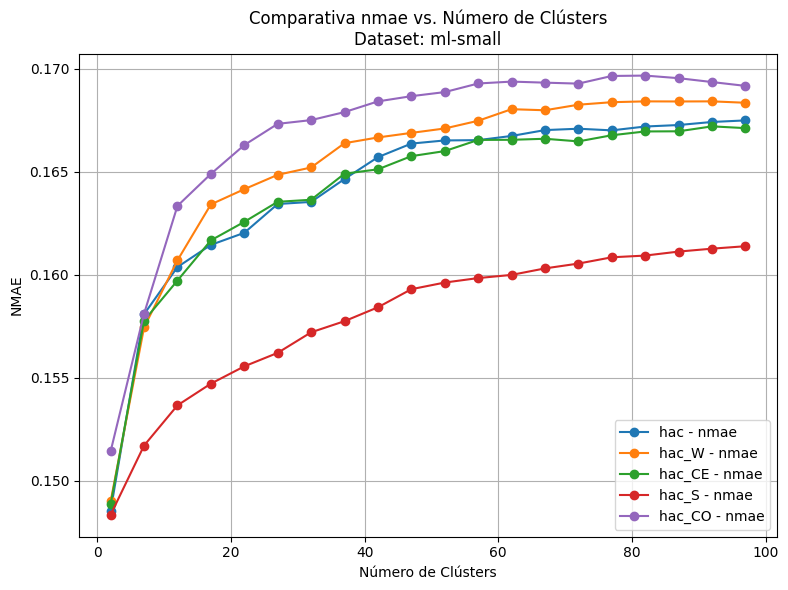

/tmp/ipykernel_351691/2182175880.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  method_color_palette = plt.cm.get_cmap('tab10').colors


Figura guardada en ../Memoria/Figuras/nrmse-euc-ml-small.png


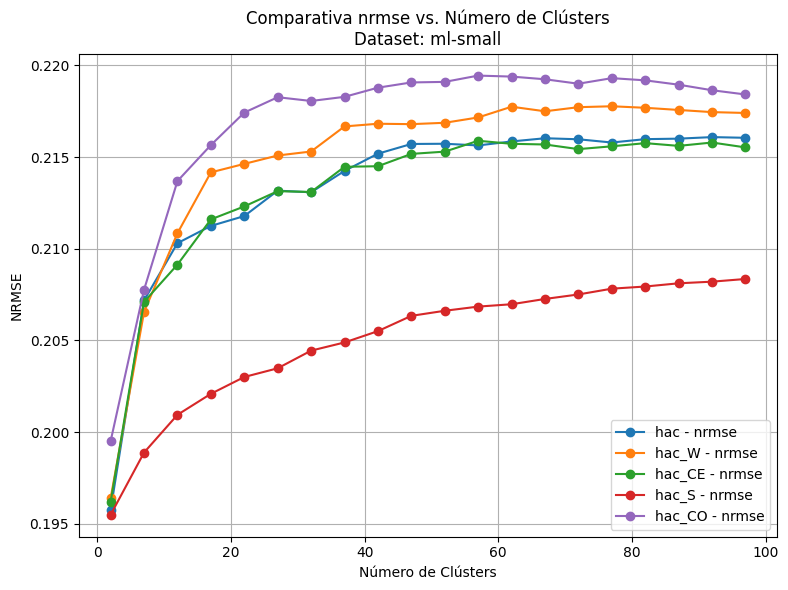

/tmp/ipykernel_351691/2182175880.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  method_color_palette = plt.cm.get_cmap('tab10').colors


Figura guardada en ../Memoria/Figuras/entropy-euc-ml-small.png


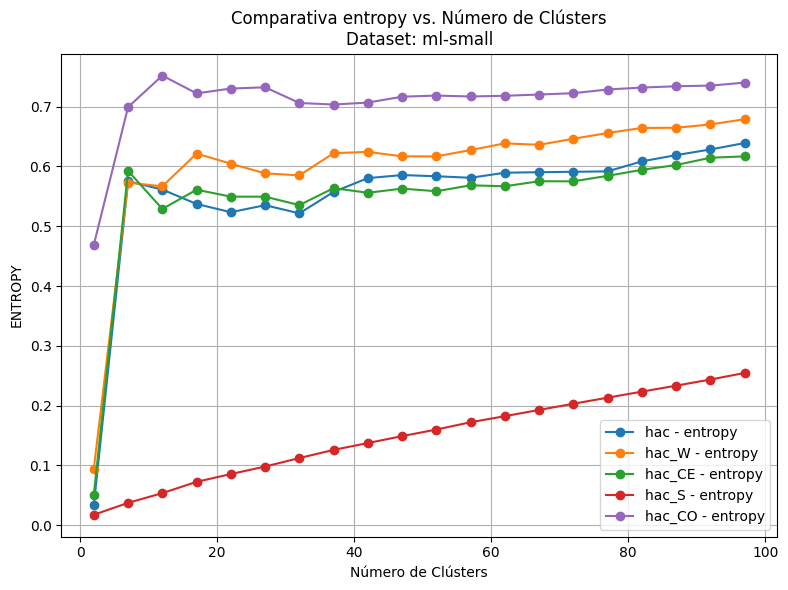

In [ ]:
plot_metrics_single_dataset(
    dataset='ml-small',
    metrics=['nmae'],
    methods= hac_methods_euclidean,
    results_file='results_hac.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

plot_metrics_single_dataset(
    dataset='ml-small',
    metrics=['nrmse'],
    methods= hac_methods_euclidean,
    results_file='results_hac.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

plot_metrics_single_dataset(
    dataset='ml-small',
    metrics=['entropy'],
    methods= hac_methods_euclidean,
    results_file='results_hac.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)


/tmp/ipykernel_351691/411695297.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  method_color_palette = plt.cm.get_cmap('tab10').colors


Figura guardada en ../Memoria/Figuras/nmae-pear-ml-small.png


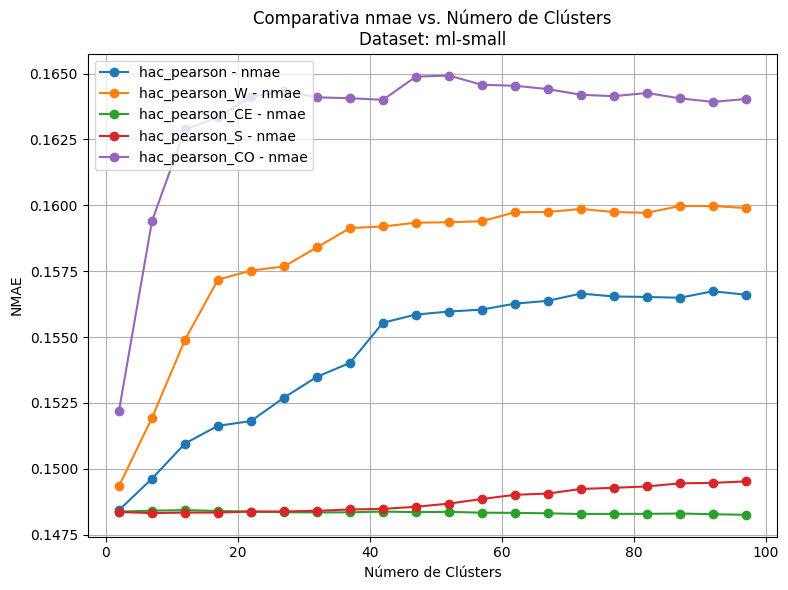

/tmp/ipykernel_351691/411695297.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  method_color_palette = plt.cm.get_cmap('tab10').colors


Figura guardada en ../Memoria/Figuras/nrmse-pear-ml-small.png


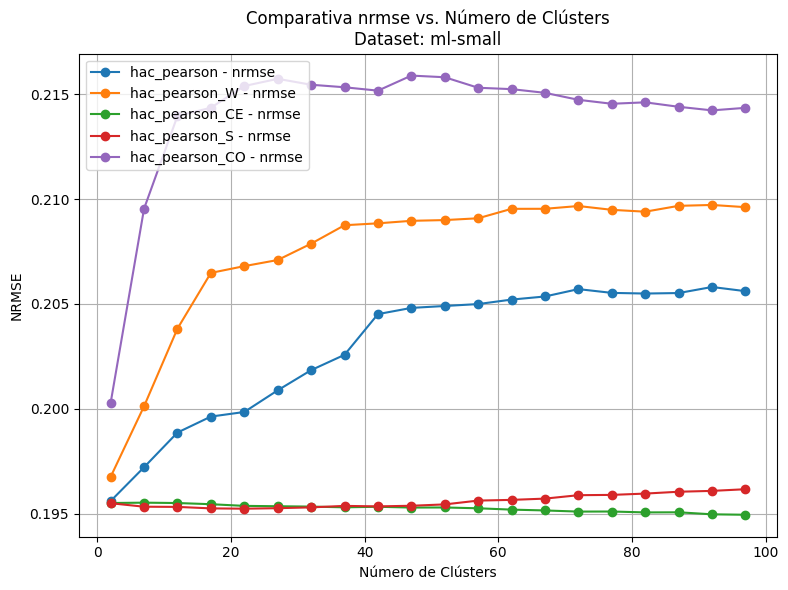

/tmp/ipykernel_351691/411695297.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  method_color_palette = plt.cm.get_cmap('tab10').colors


Figura guardada en ../Memoria/Figuras/entropy-pear-ml-small.png


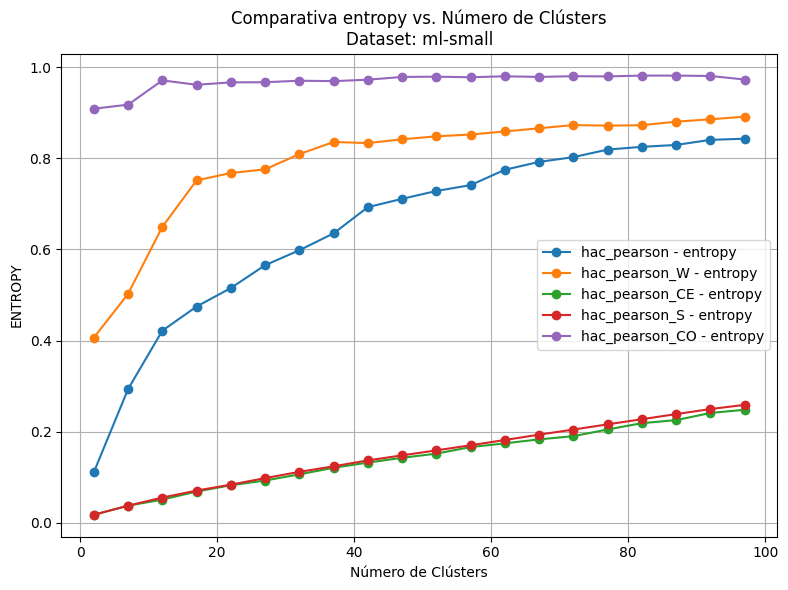

In [ ]:

plot_metrics_single_dataset(
    dataset='ml-small',
    metrics=['nmae'],
    methods= hac_methods_pearson,
    results_file='results_hac.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

plot_metrics_single_dataset(
    dataset='ml-small',
    metrics=['nrmse'],
    methods= hac_methods_pearson,
    results_file='results_hac.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)

plot_metrics_single_dataset(
    dataset='ml-small',
    metrics=['entropy'],
    methods= hac_methods_pearson,
    results_file='results_hac.csv',
    save=False,
    save_dir='../Memoria/Figuras'
)